In [1]:
#!pip install umap-learn
!pip install umap-learn

In [2]:
import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'
import pickle
import numpy as np
import umap
import matplotlib.pyplot as plt
import umap.umap_ as umap

In [3]:
!pip show umap

In [4]:
filename = 'glove_6B/glove2word2vec_model.sav'
with open(filename, 'rb') as file:
    model = pickle.load(file)

# Extract word vectors from the model
word_vectors = model

In [15]:
words_of_interest = ["beach", "ocean", "sun", "sand", "waves","tourism"]

# Remove missing words and duplicates from the list
unique_words_of_interest = list(set(words_of_interest).intersection(model.key_to_index))

# Retrieve the word vectors for the selected words
vectors_of_interest = [model[word] for word in words_of_interest if word in model.key_to_index]

if not vectors_of_interest:
    print("No valid word vectors found. Please check your input data.")
else:
    reducer = umap.UMAP(n_neighbors=100)
    umap_embeddings = reducer.fit_transform(vectors_of_interest)

/Users/AprilCoffee/opt/anaconda3/envs/tf_cpu/lib/python3.7/site-packages/umap/umap_.py:2434: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  "n_neighbors is larger than the dataset size; truncating to "


In [16]:

def drawPlt(umap_embeddings, words_of_interest, highlight_words=None):
    # Create a scatter plot of the UMAP embeddings
    plt.figure(figsize=(10, 8))
    
    # Initialize colors for all points as blue
    point_colors = ['blue'] * len(words_of_interest)
    
    # Change the color for highlighted words to red
    if highlight_words:
        for i, word in enumerate(words_of_interest):
            if word in highlight_words:
                point_colors[i] = 'red'
    
    # Scatter plot all words with smaller circles and updated colors
    plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], marker='.', s=20, c=point_colors, alpha=0.5)
    
    # Annotate points with words
    for i, word in enumerate(words_of_interest):
        if i < umap_embeddings.shape[0]:  # Check if the index is within bounds
            plt.annotate(word, (umap_embeddings[i, 0], umap_embeddings[i, 1]), fontsize=10)
    
    plt.title("UMAP Visualization of GloVe Word Embeddings")
    plt.xlabel("")
    plt.ylabel("")
    plt.show()


In [17]:
from sklearn.metrics.pairwise import cosine_similarity

# Choose a target word
target_word = "ocean"
words_of_interest = []
words_of_interest.append(target_word)
# Ensure the target word is in the vocabulary
if target_word in model.key_to_index:
    # Get the vector for the target word
    target_vector = model[target_word].reshape(1, -1)

    # Calculate cosine similarities between the target word and all other words
    similarities = cosine_similarity(target_vector, model.vectors)

    # Find the top N similar words (excluding the target word itself)
    top_n = 200  # Adjust as needed
    similar_word_indices = similarities.argsort()[0][-top_n - 1:-1][::-1]

    # Get the similar words and their similarity scores
    similar_words = [model.index_to_key[i] for i in similar_word_indices]
    similarity_scores = [similarities[0][i] for i in similar_word_indices]
    words_of_interest.extend(similar_words)

    # Print the similar words and their similarity scores
    #for word, score in zip(similar_words, similarity_scores):
    #    print(f"{word}: {score:.4f}")
#else:
#    print(f"{target_word} is not in the vocabulary.")


In [18]:
vectors_of_interest = [model[word] for word in words_of_interest if word in model.key_to_index]

if not vectors_of_interest:
    print("No valid word vectors found. Please check your input data.")
else:
    reducer = umap.UMAP(n_neighbors=100)
    umap_embeddings = reducer.fit_transform(vectors_of_interest)

In [19]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize

# Assuming you have loaded GloVe embeddings and vectors_of_interest
# vectors_of_interest is a list of word vectors

# Number of clusters (you can adjust this)
num_clusters = 20

# Normalize the word vectors (important for K-Means)
normalized_vectors = normalize(vectors_of_interest)

# Initialize and fit K-Means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(normalized_vectors)

# Get the cluster labels for each word vector
cluster_labels = kmeans.labels_

# Print the words and their respective clusters
#for word, cluster in zip(words_of_interest, cluster_labels):
#    print(f"{word}: Cluster {cluster}")

# Analyze and visualize the clusters as needed


In [11]:
import matplotlib.pyplot as plt
import umap
import numpy as np

def drawPlt_old(umap_embeddings, words_of_interest, target_word, cluster_labels, focus_cluster=None, opacity=0.5, label_opacity=1.0, label_size=12):
    # Create a scatter plot of UMAP embeddings
    plt.figure(figsize=(12, 8))

    # Define unique colors for each cluster
    unique_clusters = set(cluster_labels)
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_clusters)))

    # Lists to store cluster labels
    cluster_label_lists = [[] for _ in range(len(unique_clusters))]

    # Plot points in focus cluster with full opacity
    for cluster in unique_clusters:
        mask = cluster_labels == cluster
        if cluster == focus_cluster:
            plt.scatter(
                umap_embeddings[mask, 0], umap_embeddings[mask, 1],
                label=" ", 
                color=colors[cluster], alpha=1.0
            )
            label_alpha = 1.0  # Full opacity for labels of the focus cluster
            label_size_cluster = label_size  # Adjust label size for the focus cluster
        else:
            plt.scatter(
                umap_embeddings[mask, 0], umap_embeddings[mask, 1],
                color=colors[cluster], alpha=opacity
            )
            label_alpha = label_opacity  # Adjusted opacity for labels of other clusters
            label_size_cluster = 8  # Smaller label size for other clusters

        # Annotate points with words and set label opacity and size
        for i, word in enumerate(words_of_interest):
            if cluster_labels[i] == cluster:
                plt.annotate(word, (umap_embeddings[i, 0], umap_embeddings[i, 1]), alpha=label_alpha, fontsize=label_size_cluster)
                cluster_label_lists[cluster].append(word)

    #plt.title("UMAP Visualization of GloVe Word Embeddings")
    #plt.xlabel("UMAP Dimension 1")
    #plt.ylabel("UMAP Dimension 2")
    plt.axis('off')

    plt.legend()

    
    image_folder = "cluster_images"
    os.makedirs(image_folder, exist_ok=True)
    plt.savefig(f"{image_folder}/cluster_visualization_{focus_cluster}.png", dpi=300, bbox_inches='tight', format='png')
  
    # Show the plot
    
    # Optionally, you can specify the DPI (dots per inch) for resolution, and the format (e.g., PNG, JPEG, SVG)
    #plt.savefig('my_high_res_plot.png', dpi=300, format='png')

    plt.show()

    # Return the cluster label lists
    return cluster_label_lists




In [20]:
import matplotlib.pyplot as plt
import umap
import numpy as np

def drawPlt(umap_embeddings, selected_keywords,words_of_interest, target_word, cluster_labels, focus_cluster=None, opacity=0.5, label_opacity=1.0, label_size=12):
    # Create a scatter plot of UMAP embeddings
    plt.figure(figsize=(12, 8))

    # Define unique colors for each cluster
    unique_clusters = set(cluster_labels)
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_clusters)))

    # Lists to store cluster labels
    cluster_label_lists = [[] for _ in range(len(unique_clusters))]

    # Plot points in focus cluster with full opacity
    for cluster in unique_clusters:
        mask = cluster_labels == cluster
        
        plt.scatter(
            umap_embeddings[mask, 0], umap_embeddings[mask, 1],
            color=colors[cluster], alpha=opacity
        )
        label_alpha = label_opacity  # Adjusted opacity for labels of other clusters
        label_size_cluster = 8  # Smaller label size for other clusters

        # Annotate points with words and set label opacity and size
        #for i, word in enumerate(words_of_interest):
        #    if cluster_labels[i] == cluster:
        #        plt.annotate(word, (umap_embeddings[i, 0], umap_embeddings[i, 1]), alpha=label_alpha, fontsize=label_size_cluster)
        #        cluster_label_lists[cluster].append(word)

        


    # Annotate points with words
    for i, word in enumerate(words_of_interest):
        if word in selected_keywords:
            # Enlarge the text for selected keywords
            plt.annotate(word, (umap_embeddings[i, 0], umap_embeddings[i, 1]), alpha=1, fontsize=12)
        else:
            # Use normal text size for other keywords
            plt.annotate(word, (umap_embeddings[i, 0], umap_embeddings[i, 1]), alpha=label_opacity, fontsize=8)


                
                
    #plt.title("UMAP Visualization of GloVe Word Embeddings")
    #plt.xlabel("UMAP Dimension 1")
    #plt.ylabel("UMAP Dimension 2")
    plt.axis('off')

    #plt.legend()

    
    image_folder = "cluster_images"
    os.makedirs(image_folder, exist_ok=True)
    plt.savefig(f"{image_folder}/cluster_visualization_{focus_cluster}.png", dpi=300, bbox_inches='tight', format='png')
  
    # Show the plot
    
    # Optionally, you can specify the DPI (dots per inch) for resolution, and the format (e.g., PNG, JPEG, SVG)
    #plt.savefig('my_high_res_plot.png', dpi=300, format='png')

    #plt.show()

    # Return the cluster label lists
    return cluster_label_lists




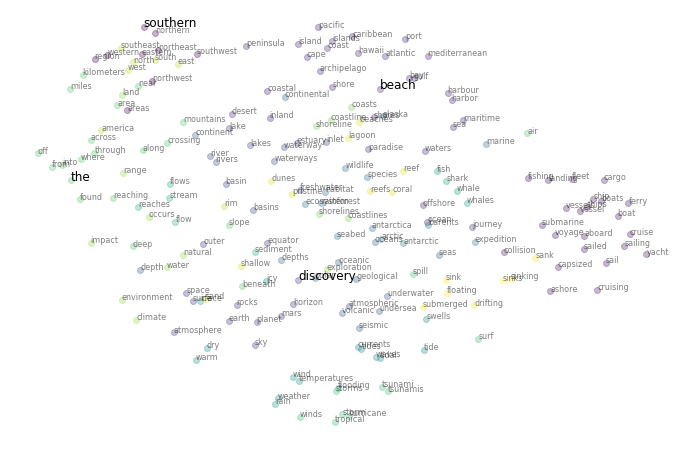

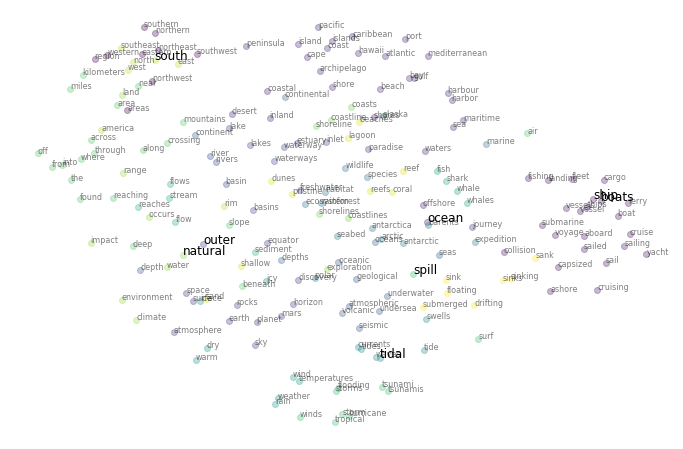

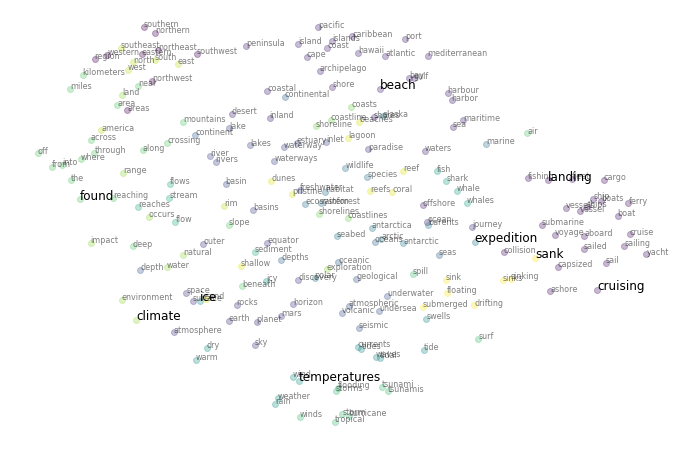

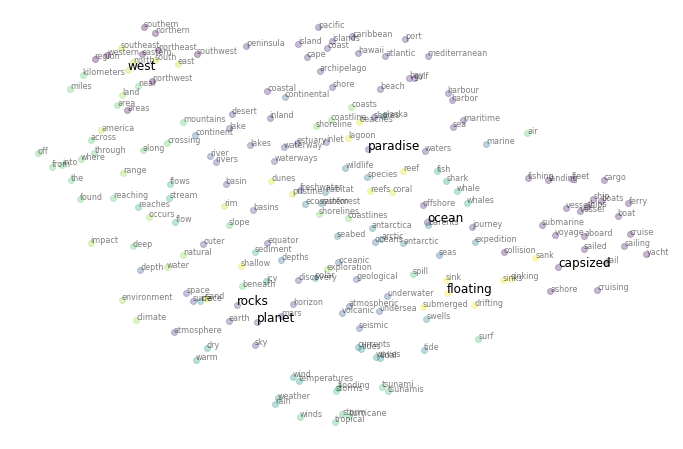

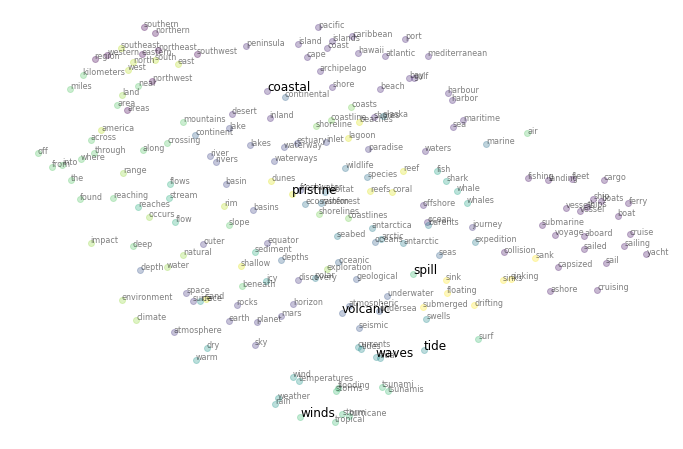

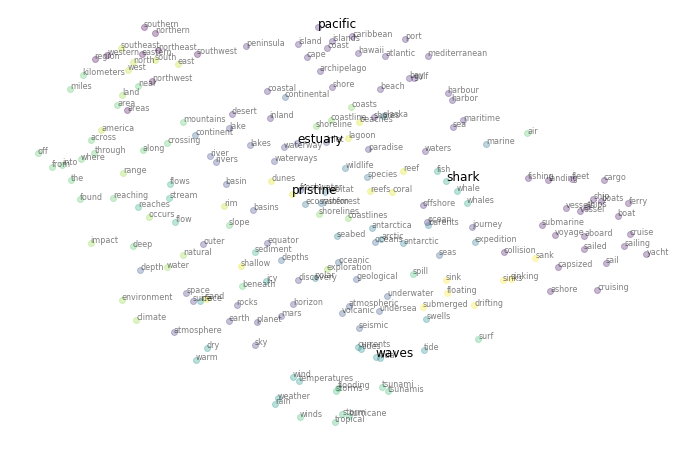

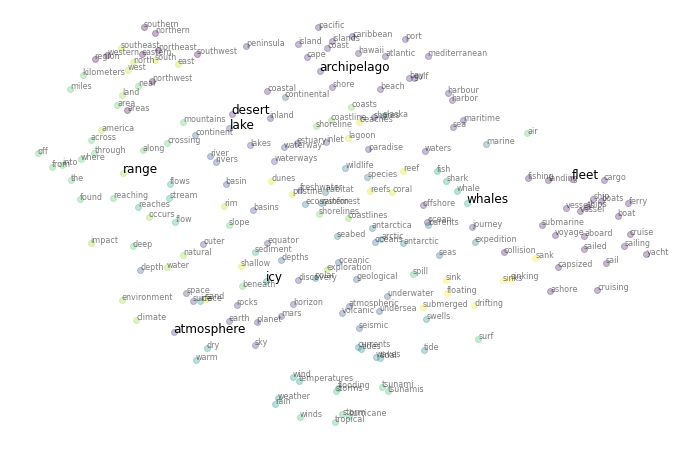

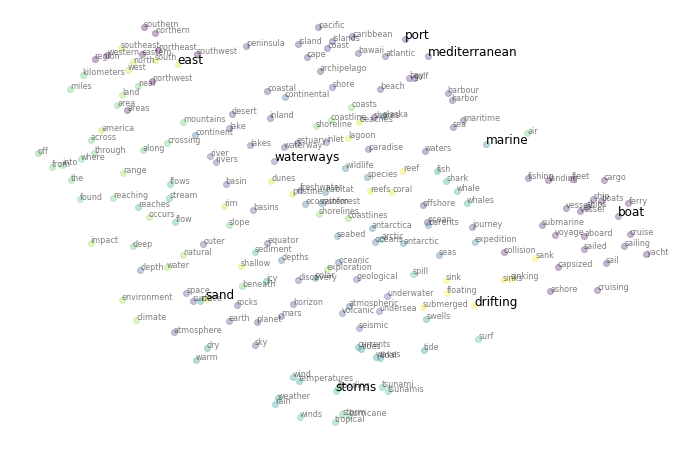

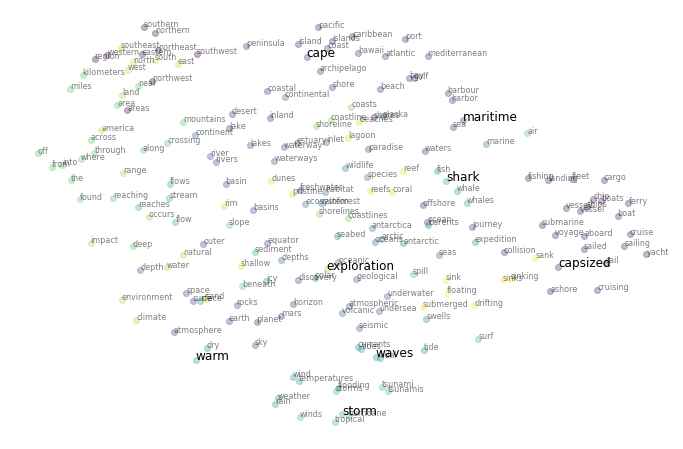

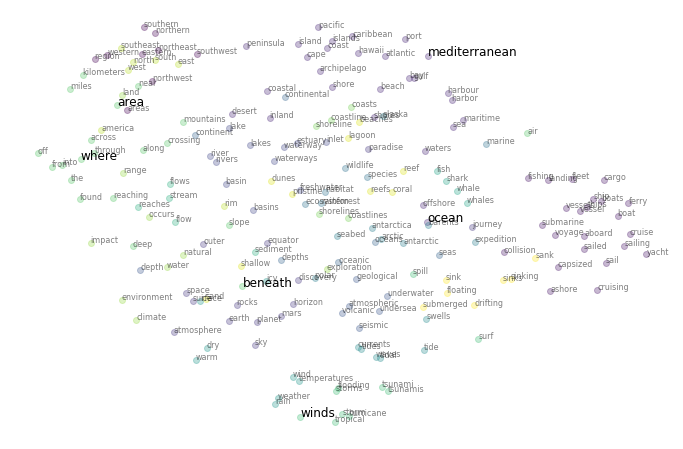

In [24]:
import random
# Prepare to save label data for CSV
all_labels = []


cluster_label_lists = []
# Generate and save plots
for i in range(10):
    
    # Select a random subset of keywords
    num_selected_keywords = random.randint(3,8)  # Adjust this number as needed
    selected_keywords = random.sample(words_of_interest, min(num_selected_keywords, len(words_of_interest)))
    
    based_word = ["beach", "ocean", "sunset", "sand", "waves","tourism"]
    selected_keywords.append(random.choice(based_word))
    cluster_label_lists.append(selected_keywords)
    
    this = drawPlt(umap_embeddings, selected_keywords,words_of_interest, target_word, cluster_labels, focus_cluster=i, opacity=0.3, label_opacity=0.5, label_size=14)
    # Collect label data
    for cluster, labels in enumerate(cluster_label_lists):
        for label in labels:
            all_labels.append([cluster, label])


In [25]:
print(cluster_label_lists)

[['the', 'southern', 'discovery', 'beach'], ['ship', 'boats', 'natural', 'outer', 'spill', 'tidal', 'south', 'ocean'], ['cruising', 'landing', 'sank', 'expedition', 'ice', 'climate', 'temperatures', 'found', 'beach'], ['rocks', 'floating', 'west', 'paradise', 'capsized', 'planet', 'ocean'], ['spill', 'winds', 'tide', 'coastal', 'pristine', 'volcanic', 'waves'], ['shark', 'pristine', 'estuary', 'pacific', 'waves'], ['range', 'lake', 'fleet', 'whales', 'archipelago', 'icy', 'atmosphere', 'desert', 'sunset'], ['waterways', 'marine', 'port', 'east', 'boat', 'storms', 'mediterranean', 'drifting', 'sand'], ['cape', 'storm', 'warm', 'maritime', 'shark', 'exploration', 'capsized', 'waves'], ['area', 'winds', 'mediterranean', 'where', 'beneath', 'ocean']]


In [43]:

import openai
import api_key
# Setting up enviornment
from base64 import b64decode
from pathlib import Path
import os
import io
import warnings
from PIL import Image
from stability_sdk import client
import stability_sdk.interfaces.gooseai.generation.generation_pb2 as generation


os.environ['STABILITY_HOST'] = 'grpc.stability.ai:443'
os.environ['STABILITY_KEY'] = api_key.dreamStudio_key()


stability_api = client.StabilityInference(
    key=os.environ['STABILITY_KEY'], # API Key reference.
    verbose=True, # Print debug messages.
    engine="stable-diffusion-768-v2-1", # Set the engine to use for generation. 
)


def chatGPT_ads(input_text):

    openai.api_key = api_key.openai_key()
    response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo",
            temperature = 1.2,
            messages=[
                {"role": "system", "content": 
                '''
                you are a travel agency, that has the ability to write fantastic advertisements based on some fake locations

                I want you to write me SHORT describtion, give briefly. based on the keyword given.
                
               '''
                },

                #{"role": "user", "content": " A photorealistic, Spectacular nature landscape, highly detailed, photo-postcard of the coast, including mountain, landscape, river, waterfall "},
                #{"role": "assistant", "content":"Spectacular nature landscape, background mountains, river with waterfall, sharp focus, hyper detailed, detail colors, haze, fog, pine trees, depth, soft contrast,  golden hour colors, photo realistic, ultra realistic, cinematic landscape photography, cinematic ligthining"},
                {"role": "user", "content": 
             '''IDEA: short describtion based on the following text''' + input_text +"NO CANVAS"}
            ]
    )
    #print(response['choices'][0]['message']['content'])
    output = response['choices'][0]['message']['content']
    return output
    #os.system("say -v anna '"+output+"'") 
    #os.system("say '"+output+"'") 

def chatGPT_old(input_text):

    openai.api_key = api_key.openai_key()

    response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo",
            temperature = 1.2,
            messages=[
                {"role": "system", "content": 
                '''
                you are a stable diffusion prompt generating machine.

                Stable Diffusion is an AI art generation model similar to DALLE.
                Below is a list of prompts that can be used to generate images with Stable Diffusion:

                - design, interrior, interriordesign Masterpiece, (photorealistic:1.4), the best quality, ultra-high res, photorealistic, realistic detailed, poster photograph, sharp focus, realistic landscape photo, shot with iPhone 13 Pro Max, shot with nikon z9 and nikkor z 70-200mm f/2. 8 VR S lens, waterall in the distance, a waterfall in the fall with a bright sky, sunset panorama, colorful digital screens) xf iq4, the glimmering orange dawn, realistic, photorealistic, aerial, drone shot, nature, ambient light, deer, detailed, hyperrealistic, sharp details, lens flare, beauty of nature, best quality, (golden hour lighting), muted colors,16K, 8K, 4K, flora and fauna, the essence of fall, colorful leaves, realistic water, realistic trees, realistic landscape, october, leaves on ground, raining, sunny, A picturesque view of a tranquil forest with leaves transitioning from the lush greens of summer to the golden hues of fall. The sun's rays pierce through the canopy, creating a play of light and shadow, emphasizing the crimson and amber tones, capturing the magic of the changing seasons, japan, tokyo, street, temple, temple gate ,#Portraiture Style-3 + Anamorphic + epic composition + golden-ratio + HDR10 + cinematography + #aweinspiring –v5 –q 2 –c 20” --style raw, HDR, ray tracing, highly detailed, 8k, ((fog)), dramatic, detailed shadows, fantastic realism, volumetric light, hyper detailed, ArtStation hq, (square aspect ratio), <lora:add_detail:0.8>, <lora:Fnaf_Vanny:0.2>
                - Spectacular nature landscape, background mountains, river with waterfall, sharp focus, hyper detailed, detail colors, haze, fog, pine trees, depth, soft contrast,  golden hour colors, photo realistic, ultra realistic, cinematic landscape photography, cinematic ligthining
                - ghost inside a hunted room, art by lois van baarle and loish and ross tran and rossdraws and sam yang and samdoesarts and artgerm, digital art, highly detailed, intricate, sharp focus, Trending on Artstation HQ, deviantart, unreal engine 5, 4K UHD image
                - red dead redemption 2, cinematic view, epic sky, detailed, concept art, low angle, high detail, warm lighting, volumetric, godrays, vivid, beautiful, trending on artstation, by jordan grimmer, huge scene, grass, art greg rutkowski
                -The Legend of Zelda landscape  atmospheric, hyper realistic, 8k, epic composition, cinematic, octane render, artstation landscape vista photography by Carr Clifton & Galen Rowell, 16K resolution, Landscape veduta photo by Dustin Lefevre & tdraw, 8k resolution, detailed landscape painting by Ivan Shishkin, DeviantArt, Flickr, rendered  in Enscape, Miyazaki, Nausicaa Ghibli, Breath of The Wild, 4k detailed post processing, artstation, rendering by octane, unreal engine —ar 16:9
                -The Lord of The Rings landscape  atmospheric, hyper realistic fantasy, 8k, epic composition, cinematic, octane render, highly detailed,artstation landscape vista painted by Carr Clifton & Galen Rowell, 16K resolution, Landscape veduta photo by Dustin Lefevre & tdraw, 8k resolution, detailed landscape painting by Ivan Shishkin, DeviantArt, Flickr, rendered  in Enscape, Miyazaki, Nausicaa Ghibli, Breath of The Wild, 4k detailed post processing,acrilic mode, artstation, rendering by octane, unreal engine —ar 16:9
                -beautiful crystal geode in a cavern, landscape, alex ross, eddie mendoza, raphael lacoste, sebastian ludke, concept art, matte painting, highly detailed, rule of thirds, dynamic lighting, cinematic, realism, realistic, photo real, detailed, magnificiant landscape, denoised, centerd 
                - ultra realistic illustration of steve urkle as the hulk, intricate, elegant, highly detailed, digital painting, artstation, concept art, smooth, sharp focus, illustration, art by artgerm and greg rutkowski and alphonse mucha
                -Landscape photo ultra realistic half bullfrog and half old hag woman with 4 arms in a swamp, dark fantasy, dead trees protrude from water dark castle in the far background, dramatic light, pale sunrise, cinematic lighting, battered, low angle, trending on artstation, 4k, hyper realistic, focused, extreme details, unreal engine 5, cinematic, masterpiece, art by studio ghibli, intricate artwork by john william turner
                – alberto seveso and geo2099 style, A highly detailed and hyper realistic portrait of a gorgeous young ana de armas, lisa frank, trending on artstation, butterflies, floral, sharp focus, studio photo, intricate details, highly detailed, by Tvera and wlop and artgerm


                taking this as example
                "Spectacular nature landscape, background mountains, river with waterfall, sharp focus, hyper detailed, detail colors, haze, fog, pine trees, depth, soft contrast,  golden hour colors, photo realistic, ultra realistic, cinematic landscape photography, cinematic ligthining"

                short description of the scene is :Spectacular nature landscape, background mountains, river with waterfall" 
                and followed by modifiers: sharp focus, hyper detailed, detail colors, haze, fog, pine trees, depth, soft contrast,  golden hour colors, photo realistic, ultra realistic, cinematic landscape photography, cinematic ligthining


                I want you to write me a prompt exactly about the idea written after IDEA. 
                Following the structure of the example prompts. 
                This means a VERY SHORT description of the scene, 
                and then followed by SHORT modifiers of single words divided by commas to alter the mood, style, lighting, and more.

               '''
                },

                {"role": "user", "content": " A photorealistic, Spectacular nature landscape, highly detailed, photo-postcard of the coast, including mountain, landscape, river, waterfall "},
                {"role": "assistant", "content":"Spectacular nature landscape, background mountains, river with waterfall, sharp focus, hyper detailed, detail colors, haze, fog, pine trees, depth, soft contrast,  golden hour colors, photo realistic, ultra realistic, cinematic landscape photography, cinematic ligthining"},
                {"role": "user", "content": 
             '''IDEA: ONE single image of photorealistic, tourism, nature landscape, ultra realistic, cinematic landscape photography,''' + input_text +"NO CANVAS"}
            ]
    )
    
    #print(response['choices'][0]['message']['content'])
    output = response['choices'][0]['message']['content']
    return output
    #os.system("say -v anna '"+output+"'") 
    #os.system("say '"+output+"'") 

    
def chatGPT(input_text):

    openai.api_key = api_key.openai_key()

    response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo",
            temperature = 1.2,
            messages=[
                {"role": "system", "content": 
                '''
                 you are a image describtion, doing describing photograph based on keywords
                 you only answer things in MAXIMUM 2 sentence!!!!
               '''
                },

                {"role": "user", "content": 
             '''IDEA: combine the following keywords:''' + input_text +"/n try to describe a photo scenary using ALL of the keyword, but in two sentences"}
            ]
    )
    
    #print(response['choices'][0]['message']['content'])
    output = response['choices'][0]['message']['content']
    return output
    #os.system("say -v anna '"+output+"'") 
    #os.system("say '"+output+"'") 

    
def stability_generate(_number,input_prompt):
    # Set up our connection to the API.
    # select the engine using. (possible for stable diffusion 2)

    # Set up our initial generation parameters.
    answers = stability_api.generate(
        prompt=input_prompt,
        steps=40, # Amount of inference steps performed on image generation. Defaults to 30. 
        cfg_scale=8.0, # Influences how strongly your generation is guided to match your prompt.
                       # Setting this value higher increases the strength in which it tries to match your prompt.
                       # Defaults to 7.0 if not specified.
        width=1024, # Generation width, defaults to 512 if not included.
        height=768, # Generation height, defaults to 512 if not included.
    )

    IMAGE_DIR = Path.cwd() / "StableDiffusion_images_new_1"
    IMAGE_DIR.mkdir(parents=True, exist_ok=True)

    fileName = str(_number) + "image.png"
    for resp in answers:
        for artifact in resp.artifacts:
            if artifact.type == generation.ARTIFACT_IMAGE:
                image_file = IMAGE_DIR / fileName
                img = Image.open(io.BytesIO(artifact.binary))
                img.save(image_file) # Save our generated images with their seed number as the filename.


                
                

In [39]:
from openai import OpenAI
client = OpenAI()

response = client.images.generate(
  model="dall-e-3",
  prompt="a white siamese cat",
  size="1024x1024",
  quality="standard",
  n=1,
)

image_url = response.data[0].url

ImportError: cannot import name 'OpenAI' from 'openai' (/Users/AprilCoffee/opt/anaconda3/envs/tf_cpu/lib/python3.7/site-packages/openai/__init__.py)

In [40]:

# Generate content and write in the same loop
for i in range(10):
    label = f"Cluster_{i}"
    #input_text = ','.join(cluster_label_lists[i])  # Adjust based on your actual cluster label data

    input_text = ','.join(cluster_label_lists[i])
    input_prompt = chatGPT(input_text)
    # Generate image
    
    print(str(i)+'\t'+input_prompt)
    #image_file = stability_generate(i, input_text)  # Adjust the function to return the filename/path

    # Generate advertisement
    prompt = f"A tourism-advertisement of based on the following keywords" + input_text
    advertisement = chatGPT_ads(prompt)

    # Write the output to CSV
    with open(csv_file, mode='a', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow([label, image_file, advertisement])

    
    stability_generate(i,input_prompt)
    chatGPT_ads(input_text)


0	In this breathtaking photograph, an awe-inspiring scene of Southern discovery unfolds before our eyes. The composition captures the tranquil beauty of a pristine, sandy beach that stretches endlessly towards the glistening ocean. The golden sunlight illuminates the entire setting, casting a warm and inviting glow on the surroundings. Walking along the smooth, undisturbed shoreline, one can feel a sense of freedom and adventure - as if embarking on a journey of discovery. The rhythmic lapping of the waves against the shore creates a soothing soundtrack, blending harmoniously with the gentle sea breeze in the air. This secluded beach, tucked away from the bustling world, invites visitors to immerse themselves in its natural wonders and experience a truly unforgettable Southern discovery.


NameError: name 'csv_file' is not defined

In [45]:
import csv
import os
import time
csv_test = "csv_test.csv"

# Save the labels to the CSV file
with open(csv_test, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(["Cluster", "Label","imagePrompt","ads"])
 

    for i in range(10):
        input_label = ','.join(cluster_label_lists[i])
        input_prompt = chatGPT(input_label)
        
        #image_file = stability_generate(i, input_text)  # Adjust the function to return the filename/path

        # Generate advertisement
        prompt = f"A Really short tourism-advertisement with maximum 3 sentences utilizing the following text" + input_prompt
        advertisement = chatGPT_ads(prompt)
        writer.writerow([i, input_label, input_prompt, advertisement])
        time.sleep(1)


In [ ]:
for i in range(20):
    print(i,end=' ')
    print(','.join(cluster_label_lists[i]))


In [172]:
texting = [
"A  photo of a photorealistic and ultra-realistic tourism landscape, capturing the mesmerizing beauty of nature with a cinematic touch. The scene showcases a diverse range of geographical locations from the northeast to the southern, southwest, northwest, western, and northern areas of a region. With impeccable attention to detail and vibrant colors, this image immerses viewers into the tranquility of Eastern landscapes.",
"A  photo landscape emerges, captivating with its pristine beauty. The scene unfolds along the coast, encompassing majestic mountains, a meandering river, and a breathtaking waterfall. In this ultra-realistic photograph, the sharp focus reveals every intricate detail, from the vibrant hues in the tree's foliage to the subtle play of light amidst the dense fog. Soft contrast and depth enhance the cinematic quality of the image, as if taken during the golden hour. While the terrain steals the show, it is not devoid of human presence. Anchored near the serene shores, a fleet of sailboats and fishing vessels can be seen, evoking a sense of adventure and maritime exploration. The essence of tourism and voyage permeates the air, with thoughts of cruising aboard a luxurious yacht or embarking on a captivating journey. The scene invites contemplation, as boats sail in harmony, finding their way amidst boundless ocean horizons. This single masterpiece of nature captured in a photorealistic medium redefines the concept of a postcard-worthy view. No canvas can contain the expanse and magnificence that unfolds before the viewer's eyes.",
"A  photo and photorealistic scene captures the essence of a tourism paradise in the heart of nature's allure. The vast expanse of the coast stretches towards the horizon, where the glistening waters of the ocean meet the golden shores. In this ultra realistic portrayal, every intricate detail is brought to life, from the crashing waves along the Atlantic and Pacific coasts to the tranquil beauty of the Mediterranean. Islands dotting the landscape and inland treasures add their charm, while the Caribbean, harbors, gulfs, capes, archipelagos, and offshore havens reveal the sheer diversity of maritime wonders. Whether it's the arid deserts meeting the sea or the bustling harbors of cosmopolitan ports, this cinematic landscape photography transports you to a world where the peninsula's enchantment never wanes. Be transported to blissful beaches, hidden bays, and the splendor of the Hawaiian islands, immersing yourself in the allure of port life along the way. It's a single image that captures the beauty and vastness of these breathtaking coastal scenes, revealing that nature's marvels truly have no canvas.",
"A  photo view of Earth's surface from a distant perspective, showcasing the stunning landscape and natural wonders. The horizon stretches endlessly, inviting viewers to embark on a journey of discovery. Featuring distinct layers of land and water, with majestic mountains, meandering rivers, and cascading waterfalls, the scene mesmerizes with its meticulous detail. The atmosphere radiates a sense of paradise, with a sprawling blue sky blending harmoniously with the outer space, creating an ethereal and enchanting atmosphere. The rocky formations along the equator add depth and texture to the already captivating landscape. This single image transports viewers to a realm of awe and wonder, capturing the essence of Earth's magnificent beauty and promising an unforgettable visual experience.",
"A  photo-realistic nature landscape depicts the beauty of a pristine coastline. Majestic mountains loom in the background as a serene river cascades down into a picturesque waterfall. The scene captures the essence of untouched wilderness with its hyper-detailed representation and vibrant colors. With cinematic lighting and a focus on realism, this ultra-realistic image transports viewers into a world of tranquility and natural wonder. The composition showcases the interplay between basins, lakes, rivers, and waterways, offering an invitation to explore the diverse estuaries and inlets of this heavenly oasis.",
"A  photo tourism postcard of a captivating underwater landscape. The scene features an ultra realistic and cinematic representation of an undersea environment. With meticulous attention to detail, the image portrays the atmospheric beauty of an underwater ecosystem. The composition captures the seismic and geological elements, highlighting the depth and powerful presence of volcanic activity. Allow your imagination to dive into this mesmerizing portrayal of nature's hidden wonders.",
"A  coastline extends as far as the eye can see, with majestic mountains rising in the background. The scene comes alive with photorealistic accuracy, capturing the essence of nature's grandeur. The colors are vivid and detailed, showcasing the intricate nuances of the landscape. Soft waves crash against the shore, creating a sense of movement and depth. The image evokes a sense of wanderlust and adventure, inviting viewers to experience the beauty of the oceanic depths and the vastness of the continental landscape.",
"A  photo journey into a marine rainforest ecosystem, capturing the pristine beauty of its diverse species and wildlife. Immerse yourself in the vibrant habitat, where lush rainforest meets serene coastal waters, unfolding an ultra-realistic cinematic landscape photography experience that transcends dimensions.",
"A , photo postcard captures the stunning beauty of the arctic landscape. Towering snow-covered mountains loom in the distance, framing an icy river that winds its way through the frigid terrain. A powerful waterfall cascades down, creating a mesmerizing display of frozen splendor. The scene is drenched in a soft, golden hour light, lending an air of tranquility to the icy surroundings. Every minute detail is meticulously depicted, from the textured snow on the mountains to the shimmering icicles clinging to the riverbanks. This ultra-realistic depiction conveys the serene yet exhilarating experience of exploring the Arctic wilderness on a polar expedition.",
"A  photo tourism postcard capturing the beauty and wonder of a coastal nature landscape. This stunning scene showcases a mesmerizing combination of elements, including majestic mountains in the background, a serene river gracefully descending into a cascading waterfall, and the rhythmic dance of waves, tides, and swells in the foreground. The image is meticulously detailed, bringing to life every texture and nuance, while the cinematic lighting accentuates the stunning colors and creates a sense of depth and immersion. With its ultra-realistic depiction, this single image transports viewers to the untamed beauty of nature, inviting them to embark on an imaginary journey along the shoreline, guided by the mesmerizing interplay of tides, currents, and the soothing sounds of crashing waves.",
"A  photo postcard-like image showcases a tourism hotspot enveloped in an ultra-realistic cinematic landscape. The scene captures the grandeur of nature as jagged mountain peaks rise in the background while a meandering river leads to a picturesque waterfall. The image reflects the dynamic weather conditions, with gusts of wind causing leaves to rustle and ripples forming on the surface of the river. Rain cascades down from the sky, creating a glistening effect on the foliage. The icy temperatures dominate the environment, giving way to frosted surfaces and a sense of frozen tranquility. Despite the dry and icy atmosphere, there's a warmth exuded by the golden hour colors, infusing the landscape with a magical glow that brings the scene to life. This imagery depicts the perfect blend of natural beauty and cinematic artistry, transporting viewers to a world where they can almost feel the wind and experience the changing seasons firsthand.",
"A , photo nature landscape captured in one single image. The scene features a majestic coastline, adorned with towering mountains, an expansive river flowing gracefully, and a cascading waterfall. The composition is meticulously detailed, showcasing the intricate colors and textures of the surroundings. The atmosphere is enhanced with a touch of haze and a soft contrast, creating depth and a sense of tranquility. As the golden hour light bathes the landscape, it illuminates the stunning nature with a warm and inviting glow. Adding a touch of wonder and excitement, the picture also includes a group of friendly fish, a magnificent whale, and a graceful shark, reminding viewers of the rich biodiversity that thrives beneath the surface. This tourism-inspired photo-postcard captures the essence of the location, providing a truly unforgettable visual experience.",
"photo the breathtaking beauty of a photorealistic tourism destination with a stunning nature landscape. This ultra-realistic cinematic landscape photography encapsulates the essence of serenity as a majestic stream gracefully flows and reaches its destination. The utmost attention to detail brings this landscape to life, from the mesmerizing flow of the water to the subtle movement of sediment. Immerse yourself in this visual masterpiece that transports you to a world where nature's wonders come alive in vivid realism. An image so mesmerizing, it needs no canvas to hold its splendor.",
"A  photo capturing the raw beauty and destructive power of nature, presenting a breathtaking tourism-inspired landscape immersed in ultra-realistic detail. This dynamic scene showcases a tropical paradise besieged by a raging storm, fierce winds whipping through the air, churning surf crashing onto the shore, threatening tsunamis that reverberate the landscape, ominous storm clouds looming overhead. The image depicts the raw force of nature as it unleashes its fury, evoking a sense of awe and respect. The composition is expertly crafted with cinematic flair, conveying the intensity of flooding, hurricane-like conditions without confines, resulting in a truly immersive experience that transcends the boundaries of a traditional canvas.",
"A  photo postcard of a tourism hotspot in a stunning nature landscape. The scene is captured with ultra-realistic precision, showcasing the cinematic beauty of the surroundings. As we traverse along, beneath, and above the area, our eye is drawn to the magnificent mountains that slope into the deep valley. The image takes us on a visual journey, crossing rivers and reaching panoramic viewpoints that overlook the vast expanse. The level of detail is mesmerizing, capturing every moss-covered rock and swaying tree near and far as they are kissed by golden-hour light. No canvas or medium can contain the immersive experience this image evokes, transporting us to a place where beauty knows no bounds.",
"A  photo nature landscape captured on the coastline, displaying the stunning beauty of the pristine shore. This ultra realistic image showcases the scenic charm of the coast, with its magnificent mountains, meandering river, and cascading waterfall. The highly detailed depiction brings forth the vibrant colors, creating a mesmerizing scene enveloped in a soft haze and mist. The composition and lighting evoke a cinematic quality, adding a touch of enchantment to this extraordinary coastal panorama.",
"A  photo showcasing a stunning nature landscape: a captivating coastline view where majestic mountains meet a flowing river that gracefully cascades down a breathtaking waterfall. The image depicts the grandeur of untouched nature, with its highly detailed elements capturing the richness of colors, enhanced by a soft contrast to heighten the viewer's experience. Haze and fog add a touch of atmospheric mystique, complementing the sprawling pine trees that line the captivating scene. As the sunlight bathes the landscape, the golden hour colors create an ethereal ambiance, amplifying the realism and cinematic allure of the photograph. This serene natural environment serves as a reminder of the delicate balance between human exploration and the preservation of our environment, emphasizing the need to maintain and protect the impact we have on our planet's precious land and the climate that sustains it.",
"A  photo portrayal of a tourism hotspot in a nature landscape, capturing the essence of the southeastern, eastern, northern, and southern regions of America. This picturesque scene showcases a majestic mountain range and a winding river leading to a magnificent waterfall. The image displays ultra-realistic details, showcasing every hue of the vibrant landscape. Cinematic lighting enhances the overall atmosphere, creating a sense of depth and bringing the scenic beauty to life. With no boundaries restricting the display, this image transports viewers to the stunning rim of nature's magnificent canvas.",
"A  photo photorealistic portrayal of a pristine nature landscape, capturing the essence of a picturesque beach with coral reefs and a mesmerizing lagoon. The ultra realistic depiction showcases the stunning interplay of vibrant colors, crystal clear water, and powdery sand. With cinematic landscape photography techniques and meticulous attention to detail, this image immerses viewers in the tranquil beauty of shallow waters and the majestic dunes. The scene invites tourists to explore this untouched paradise and discover the wonders beneath the surface.",
"In a stunning display of photorealistic artistry, behold a tourism-worthy nature landscape captured in an ultra realistic, cinematic landscape photography style. The scene depicts a mesmerizing coast with a majestic mountain towering in the background, while a serene river gracefully winds its way towards a magnificent waterfall. As the soft golden hour light bathes the surroundings, a sense of tranquility fills the air. However, taking an unexpected turn, the image holds a twist as elements of sinking, submerged, floating, drifting, and the plight of a sinking entity emerge, imparting an eerie and thought-provoking ambiance. Every detail, from the subtle hues and textures of the environment to the play of light reflecting on the water's surface, is meticulously depicted with unrivaled precision. This masterpiece transports you to the enchanting depths of a sinking landscape, igniting your senses and sparking imagination. Experience the intricate beauty of this scene as it resonates with realism and cinematic allure, inviting you to ponder the mysteries that lie beneath the surface.",
]



def stability_generate(_number,input_prompt):
    # Set up our connection to the API.
    # select the engine using. (possible for stable diffusion 2)

    # Set up our initial generation parameters.
    answers = stability_api.generate(
        prompt=input_prompt,
        steps=40, # Amount of inference steps performed on image generation. Defaults to 30. 
        cfg_scale=8.0, # Influences how strongly your generation is guided to match your prompt.
                       # Setting this value higher increases the strength in which it tries to match your prompt.
                       # Defaults to 7.0 if not specified.
        width=1024, # Generation width, defaults to 512 if not included.
        height=768, # Generation height, defaults to 512 if not included.
    )

    IMAGE_DIR = Path.cwd() / "StableDiffusion_images_copy5"
    IMAGE_DIR.mkdir(parents=True, exist_ok=True)

    fileName = str(_number) + "image.png"
    for resp in answers:
        for artifact in resp.artifacts:
            if artifact.type == generation.ARTIFACT_IMAGE:
                image_file = IMAGE_DIR / fileName
                img = Image.open(io.BytesIO(artifact.binary))
                img.save(image_file) # Save our generated images with their seed number as the filename.


                
for i in range(20):
    
    stability_generate(i, "a realistic photograph, travel, beach, coastline, including the following attribute"+','.join(cluster_label_lists[i]))  # Adjust the function to return the filename/path
